# DAT 402 – Project 2  
## Predicting Household Income in the PSID: Comparing Linear Regression, LASSO, and Random Forest

**Students:** Gaurang Mohan, Roshan Ramakrishnan
**Course:** DAT 402 – Fall 2025  

---

### Research Question

Using panel data from the Panel Study of Income Dynamics (PSID), which demographic and household characteristics  
(e.g., age, race, family size, employment status, and homeownership) are the strongest predictors of household income?

We extend our Project 1 analysis by comparing three modeling approaches on the same cleaned PSID dataset:

1. **Ordinary Least Squares (OLS)** with year fixed effects,  
2. **LASSO regression** (L₁-regularized linear model), and  
3. **Random Forest regression**.

The goal is to understand both:
- how well each method predicts log household income out of sample, and  
- whether different methods highlight different variables as the most important determinants of income.


#Setup: install & import libraries

In [ ]:
# Core numeric + data libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling + evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
import os


# Plot style
sns.set(style="whitegrid", context="talk")

print("Libraries imported.")


Libraries imported.


In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")  # nicer background + grid
plt.rcParams.update({
    "figure.figsize": (7, 4),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})


##Mount google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#
data_path = "/content/drive/My Drive/dat402_project2/psid_long.csv"

df = pd.read_csv(data_path)
df.shape


(182852, 12)

## Data Wrangling & Feature Engineering

In this section I construct a clean modeling dataset from the PSID panel.
I focus on predicting log household income using demographic and household
variables (year, decade, homeownership, family size, age, sex, race, employment).


In [ ]:

cols_needed = [
    'income',
    'year',
    'decade',
    'own_or_rent',
    'family_size',
    'head_age',
    'head_sex',
    'head_race',
    'employment_now'
]

df_model = df[cols_needed].dropna().copy()
print("Shape after dropping rows with missing key fields:", df_model.shape)

df_model.head()


Shape after dropping rows with missing key fields: (17924, 9)


,income,year,decade,own_or_rent,family_size,head_age,head_sex,head_race,employment_now
1,23274.0,1984,1960s,1.0,8.0,45.0,1.0,1.0,1.0
2,11948.0,1989,1960s,1.0,8.0,45.0,1.0,1.0,1.0
3,11948.0,1989,1960s,1.0,8.0,45.0,1.0,1.0,1.0
4,9365.0,1992,1960s,1.0,8.0,45.0,1.0,1.0,1.0
5,5423.0,1993,1960s,1.0,8.0,45.0,1.0,1.0,1.0


In [ ]:
import numpy as np

# Main target
df_model['log_income'] = np.log1p(df_model['income'])

# Quick sanity check on distribution
df_model[['income', 'log_income']].describe()


,income,log_income
count,1.792400e+04,17924.000000
mean,4.787179e+04,10.215969
std,7.351651e+04,1.307575
min,0.000000e+00,0.000000
25%,1.500000e+04,9.615872
50%,3.150000e+04,10.357775
75%,5.784775e+04,10.965587
max,3.219550e+06,14.984752


In [ ]:
# Separate features and target
numeric_cols = ['year', 'family_size', 'head_age']
categorical_cols = ['decade', 'own_or_rent', 'head_sex', 'head_race', 'employment_now']

X = df_model[numeric_cols + categorical_cols]
y = df_model['log_income']

# One-hot encode categoricals (drop_first=True to avoid dummy trap)
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X_encoded.shape, y.shape


((17924, 19), (17924,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((14339, 19), (3585, 19))

## Exploratory Data Analysis

Here I summarize the distribution of income and log income, and how income varies across time and key groups.


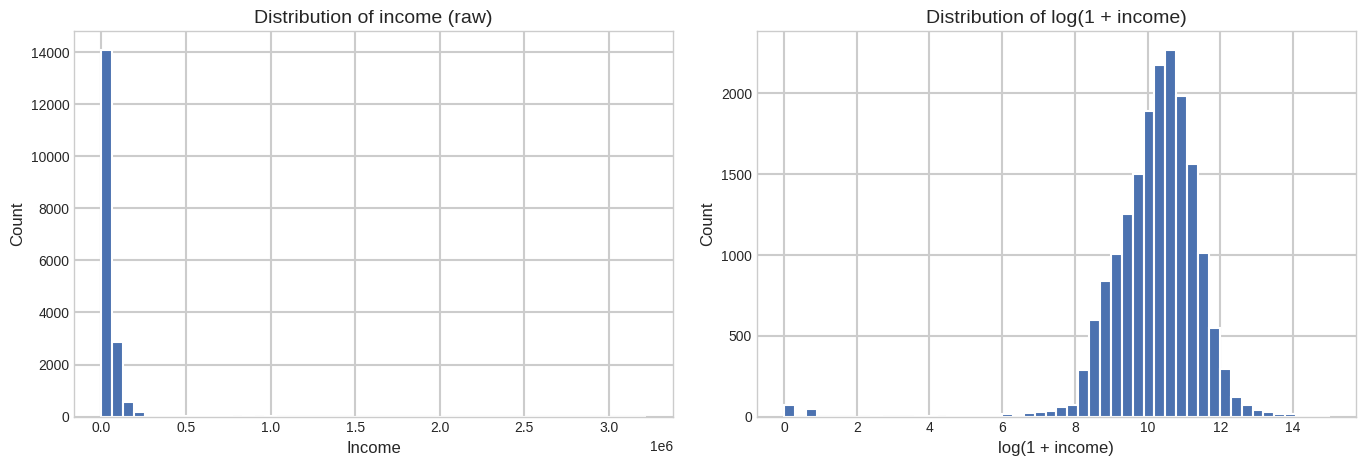

Saved figure to: /content/drive/MyDrive/dat402_project2/figures/income_histograms.png


In [ ]:
fig_path = "/content/drive/MyDrive/dat402_project2/figures/income_histograms.png"
os.makedirs(os.path.dirname(fig_path), exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_model['income'], bins=50)
axes[0].set_title("Distribution of income (raw)")
axes[0].set_xlabel("Income")
axes[0].set_ylabel("Count")

axes[1].hist(df_model['log_income'], bins=50)
axes[1].set_title("Distribution of log(1 + income)")
axes[1].set_xlabel("log(1 + income)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()
fig.tight_layout()

# 🔹 Save to Drive
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

# (Optional) still show in notebook
plt.show()

print("Saved figure to:", fig_path)


## Model 1 – OLS Linear Regression (Baseline)

Here I fit a standard linear regression model to predict log household income
using demographic and household characteristics (age, family size, race, sex,
employment, homeownership, decade, and year).
I use the same train/test split for all models and report RMSE and R² on the test set.

In [ ]:
import statsmodels.api as sm

# 1. Add intercept term
X_train_const = sm.add_constant(X_train)
X_test_const  = sm.add_constant(X_test, has_constant='add')


X_train_const = X_train_const.astype(float)
X_test_const  = X_test_const.astype(float)
y_train_ols   = y_train.astype(float)
y_test_ols    = y_test.astype(float)

# 3. Fit OLS
ols_model = sm.OLS(y_train_ols, X_train_const).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     252.6
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        11:44:21   Log-Likelihood:                -22310.
No. Observations:               14339   AIC:                         4.466e+04
Df Residuals:                   14319   BIC:                         4.481e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -12.0802      2

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred_ols = ols_model.predict(X_test_const)

rmse_ols = np.sqrt(mean_squared_error(y_test_ols, y_pred_ols))
r2_ols   = r2_score(y_test_ols, y_pred_ols)

print(f"OLS test RMSE: {rmse_ols:.3f}")
print(f"OLS test R²:   {r2_ols:.3f}")


OLS test RMSE: 1.046
OLS test R²:   0.282


In [ ]:
coef_df = pd.DataFrame({
    'feature': X_train_const.columns,
    'coef_ols': ols_model.params.values
}).sort_values(by='coef_ols', key=abs, ascending=False)

coef_df.head(15)


,feature,coef_ols
0,const,-12.080200
8,decade_2010s,1.086621
16,employment_now_2.0,-0.598830
11,head_sex_2.0,-0.571999
12,head_race_2.0,-0.540178
7,decade_2000s,0.506371
4,decade_1970s,-0.490762
5,decade_1980s,0.487539
13,head_race_3.0,-0.478131
10,own_or_rent_8.0,-0.319608


## Model 2 – LASSO Regression

Here I fit an L₁-regularized linear regression (LASSO) on the same features used in the OLS model.
I standardize the predictors, use 5-fold cross-validation to choose the penalty parameter,
and evaluate test RMSE and R² on the same train/test split.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

# Pipeline: scale features then fit LASSO with cross-validation
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LassoCV(cv=5, random_state=42))
])

lasso_pipe.fit(X_train, y_train_ols)

# Best alpha (lambda) chosen by CV
best_alpha = lasso_pipe.named_steps['model'].alpha_
print("Best alpha (L1 penalty) from CV:", best_alpha)


Best alpha (L1 penalty) from CV: 0.0004536923709251691


In [ ]:
y_pred_lasso = lasso_pipe.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test_ols, y_pred_lasso))
r2_lasso   = r2_score(y_test_ols, y_pred_lasso)

print(f"LASSO test RMSE: {rmse_lasso:.3f}")
print(f"LASSO test R²:   {r2_lasso:.3f}")


LASSO test RMSE: 1.046
LASSO test R²:   0.282


In [ ]:
# Get LASSO coefficients in the original feature space
lasso_coefs = lasso_pipe.named_steps['model'].coef_

lasso_coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef_lasso': lasso_coefs
})

# Sort by absolute value
lasso_coef_df = lasso_coef_df.sort_values(
    by='coef_lasso',
    key=lambda s: s.abs(),
    ascending=False
)

lasso_coef_df.head(15)


,feature,coef_lasso
2,head_age,-0.317265
11,head_race_2.0,-0.239892
10,head_sex_2.0,-0.235960
0,year,0.114620
15,employment_now_2.0,-0.089150
17,employment_now_4.0,-0.070819
9,own_or_rent_8.0,-0.065975
18,employment_now_5.0,0.056816
8,own_or_rent_5.0,-0.055001
12,head_race_3.0,-0.054556


In [ ]:
n_zero = (lasso_coefs == 0).sum()
n_nonzero = (lasso_coefs != 0).sum()
print(f"LASSO non-zero coefficients: {n_nonzero} (out of {len(lasso_coefs)})")


LASSO non-zero coefficients: 19 (out of 19)


In [ ]:
results = pd.DataFrame({
    'model': ['OLS', 'LASSO'],
    'RMSE': [rmse_ols, rmse_lasso],
    'R2': [r2_ols, r2_lasso]
})

results


,model,RMSE,R2
0,OLS,1.046289,0.281767
1,LASSO,1.046288,0.281769


## Model 3 – Random Forest Regression

Here we fit a Random Forest regressor on the same features to capture nonlinear
relationships and interactions (e.g., between age, year, employment, and race).
I again use the same train/test split and compare test RMSE and R² with OLS and LASSO.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train_ols)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test_ols, y_pred_rf))
r2_rf   = r2_score(y_test_ols, y_pred_rf)

print(f"Random Forest test RMSE: {rmse_rf:.3f}")
print(f"Random Forest test R²:   {r2_rf:.3f}")


Random Forest test RMSE: 1.103
Random Forest test R²:   0.201


In [ ]:
rf_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

rf_importances.head(10)


,feature,importance
2,head_age,0.313000
0,year,0.234594
1,family_size,0.149502
10,head_sex_2.0,0.141257
11,head_race_2.0,0.048765
8,own_or_rent_5.0,0.039799
9,own_or_rent_8.0,0.014537
15,employment_now_2.0,0.010449
16,employment_now_3.0,0.010270
17,employment_now_4.0,0.008589


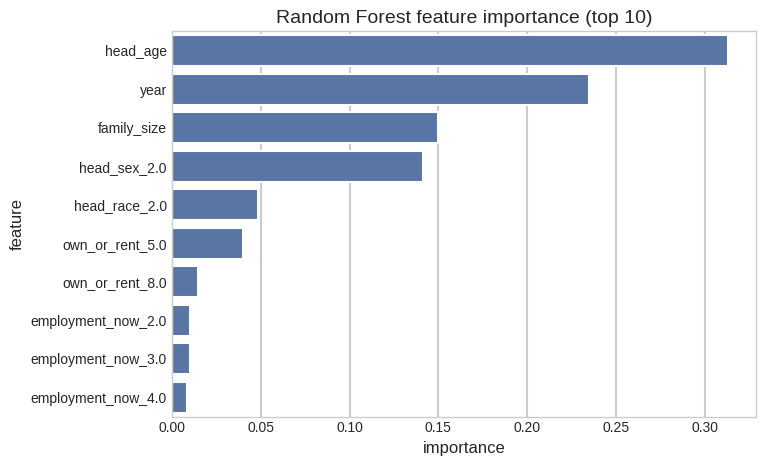

In [ ]:
top_k = 10
top_imp = rf_importances.head(top_k)

plt.figure(figsize=(8, 5))
sns.barplot(data=top_imp, x='importance', y='feature')
plt.title(f"Random Forest feature importance (top {top_k})")
plt.tight_layout()
plt.show()


### 3.1 Model specification and time variables

I model log household income as:

\[
\log(1 + \text{income}_{it})
= \alpha + \beta^\top X_{it}
+ \delta_{\text{year}} \cdot \text{year}_{it}
+ \sum_{d \neq \text{1960s}} \gamma_d \, \mathbb{1}(\text{decade}_{it} = d)
+ \varepsilon_{it},
\]

where \(X_{it}\) includes head age, sex, race, family size, employment status, and own/rent.

- `year` is a **numeric** predictor (e.g. 1984, 1989, …) that captures a smooth time trend.
- `decade` is a **categorical** variable (1960s, 1970s, …). In the model I convert it to dummy variables like
  `decade_1970s`, `decade_1980s`, … using one-hot encoding, with the 1960s as the reference decade.
- These decade dummies are **differences in mean log income relative to the 1960s**, *holding other variables fixed*.
  They are not “presence of data” indicators.


In [ ]:
results = pd.DataFrame({
    'model': ['OLS', 'LASSO', 'Random Forest'],
    'RMSE': [rmse_ols, rmse_lasso, rmse_rf],
    'R2':   [r2_ols,  r2_lasso,  r2_rf]
})

results


,model,RMSE,R2
0,OLS,1.046289,0.281767
1,LASSO,1.046288,0.281769
2,Random Forest,1.103447,0.201150


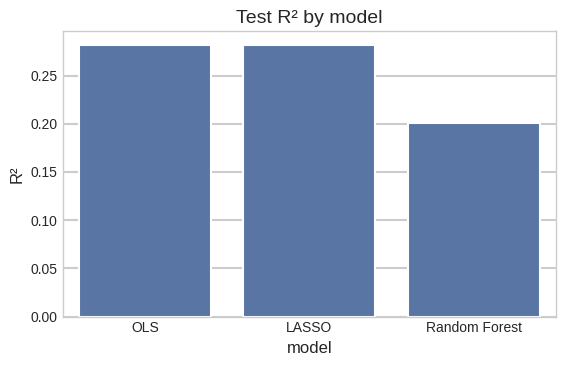

In [ ]:
results
plt.figure(figsize=(6,4))
sns.barplot(data=results, x='model', y='R2')
plt.title("Test R² by model")
plt.ylabel("R²")
plt.tight_layout()
plt.show()


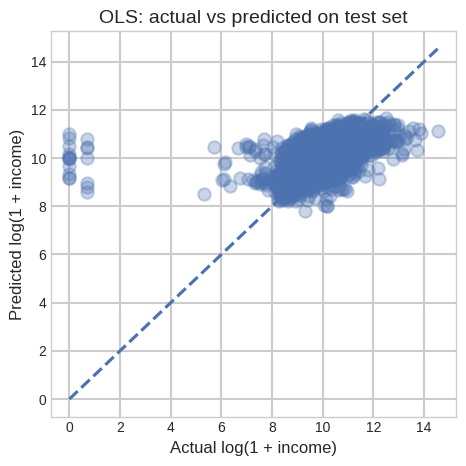

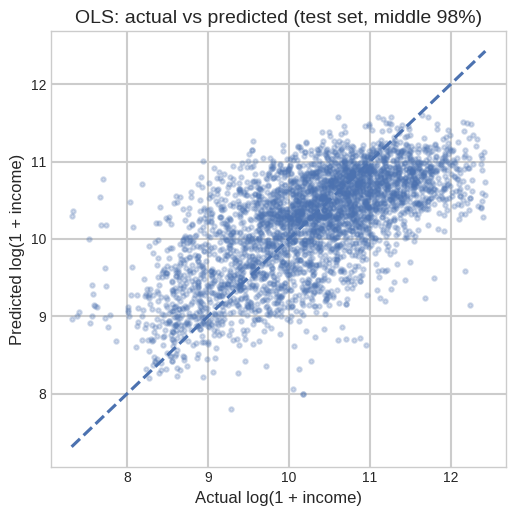

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_test_ols, y_pred_ols, alpha=0.3)
plt.plot([y_test_ols.min(), y_test_ols.max()],
         [y_test_ols.min(), y_test_ols.max()],
         linestyle='--')
plt.xlabel("Actual log(1 + income)")
plt.ylabel("Predicted log(1 + income)")
plt.title("OLS: actual vs predicted on test set")
plt.tight_layout()
plt.show()


# Using the zoomed middle 98% version is best
low, high = np.percentile(y_test_ols, [1, 99])
mask = (y_test_ols >= low) & (y_test_ols <= high)

y_actual_zoom = y_test_ols[mask]
y_pred_zoom   = y_pred_ols[mask]

fig, ax = plt.subplots(figsize=(5.5, 5.5))

ax.scatter(y_actual_zoom, y_pred_zoom, alpha=0.25, s=10)

min_val = min(y_actual_zoom.min(), y_pred_zoom.min())
max_val = max(y_actual_zoom.max(), y_pred_zoom.max())
ax.plot([min_val, max_val], [min_val, max_val], linestyle="--")

ax.set_xlabel("Actual log(1 + income)")
ax.set_ylabel("Predicted log(1 + income)")
ax.set_title("OLS: actual vs predicted (test set, middle 98%)")

fig.tight_layout()
plt.show()
#hexbin


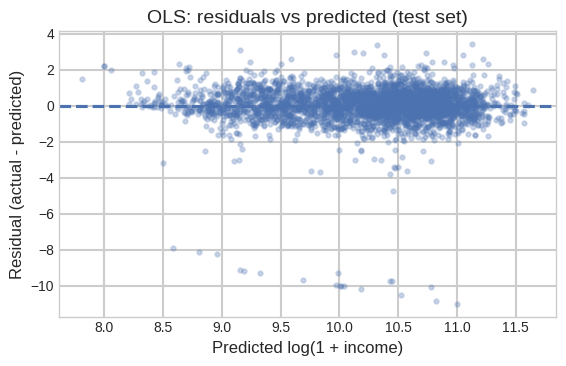

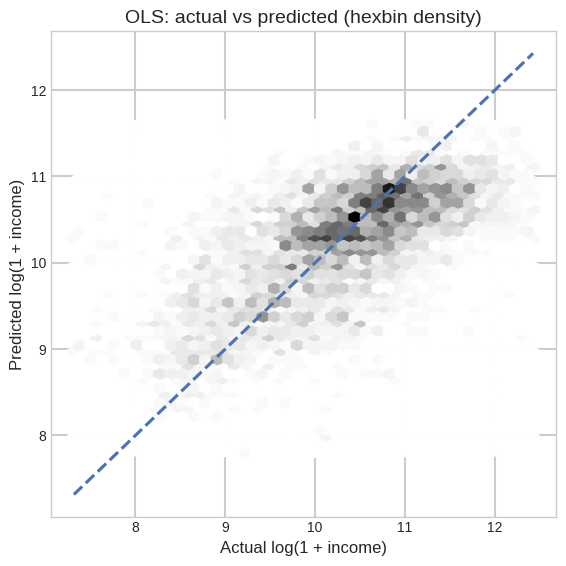

In [ ]:
residuals = y_test_ols - y_pred_ols

plt.figure(figsize=(6,4))
plt.scatter(y_pred_ols, residuals, alpha=0.25, s=10)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted log(1 + income)")
plt.ylabel("Residual (actual - predicted)")
plt.title("OLS: residuals vs predicted (test set)")
plt.tight_layout()
plt.show()
#hexbin
plt.figure(figsize=(6,6))
plt.hexbin(y_actual_zoom, y_pred_zoom, gridsize=40)
min_val = min(y_actual_zoom.min(), y_pred_zoom.min())
max_val = max(y_actual_zoom.max(), y_pred_zoom.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')

plt.xlabel("Actual log(1 + income)")
plt.ylabel("Predicted log(1 + income)")
plt.title("OLS: actual vs predicted (hexbin density)")
plt.tight_layout()
plt.show()


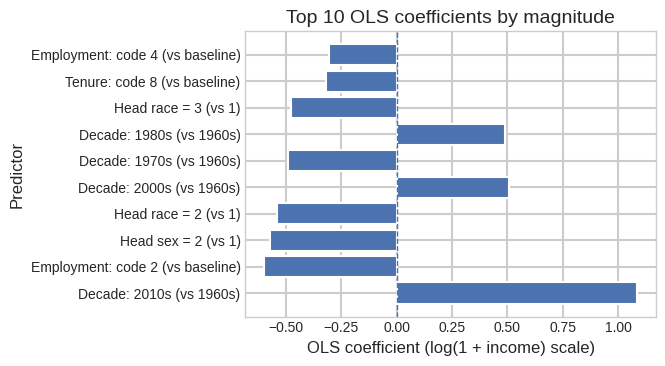

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


pretty_names = {
    'const': 'Intercept',
    'year': 'Year (calendar)',
    'head_age': 'Head age (years)',
    'family_size': 'Family size',
    'head_sex_2.0': 'Head sex = 2 (vs 1)',
    'head_race_2.0': 'Head race = 2 (vs 1)',
    'head_race_3.0': 'Head race = 3 (vs 1)',
    'head_race_7.0': 'Head race = 7 (vs 1)',
    'head_race_9.0': 'Head race = 9 (vs 1)',
    'own_or_rent_5.0': 'Tenure: code 5 (vs baseline)',
    'own_or_rent_8.0': 'Tenure: code 8 (vs baseline)',
    'employment_now_2.0': 'Employment: code 2 (vs baseline)',
    'employment_now_3.0': 'Employment: code 3 (vs baseline)',
    'employment_now_4.0': 'Employment: code 4 (vs baseline)',
    'employment_now_5.0': 'Employment: code 5 (vs baseline)',
    'decade_1970s': 'Decade: 1970s (vs 1960s)',
    'decade_1980s': 'Decade: 1980s (vs 1960s)',
    'decade_1990s': 'Decade: 1990s (vs 1960s)',
    'decade_2000s': 'Decade: 2000s (vs 1960s)',
    'decade_2010s': 'Decade: 2010s (vs 1960s)',
}

# Build a DataFrame of coefficients
coef_df = pd.DataFrame({
    "feature": X_train_const.columns,
    "coef_ols": ols_model.params.values
})

# Add human-readable names
coef_df["pretty_feature"] = coef_df["feature"].map(
    lambda f: pretty_names.get(f, f)
)

# Drop the intercept if you don't want it on the slide
coef_df_no_const = coef_df[coef_df["feature"] != "const"]

# Take top k by absolute coefficient size
top_k = 10
top_coef = coef_df_no_const.reindex(
    coef_df_no_const["coef_ols"].abs().sort_values(ascending=False).index
).head(top_k)

# Plot as horizontal bar chart
plt.figure(figsize=(7, 4))
plt.barh(top_coef["pretty_feature"], top_coef["coef_ols"])
plt.axvline(0, linestyle="--", linewidth=1)
plt.xlabel("OLS coefficient (log(1 + income) scale)")
plt.ylabel("Predictor")
plt.title(f"Top {top_k} OLS coefficients by magnitude")
plt.tight_layout()
plt.show()


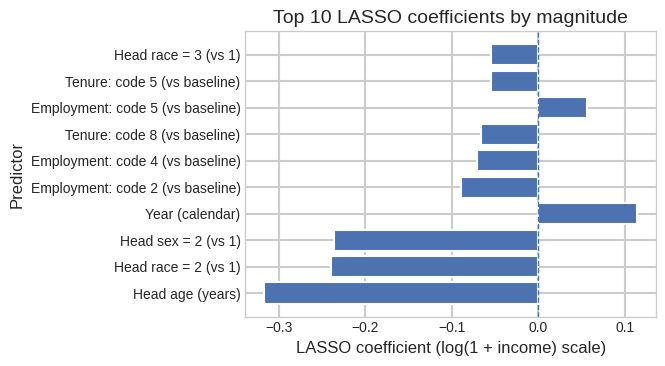

In [ ]:
lasso_coefs = lasso_pipe.named_steps['model'].coef_

lasso_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef_lasso": lasso_coefs
})
lasso_df["pretty_feature"] = lasso_df["feature"].map(
    lambda f: pretty_names.get(f, f)
)

lasso_df_nonzero = lasso_df[lasso_df["coef_lasso"] != 0]

top_k = 10
top_lasso = lasso_df_nonzero.reindex(
    lasso_df_nonzero["coef_lasso"].abs().sort_values(ascending=False).index
).head(top_k)

plt.figure(figsize=(7, 4))
plt.barh(top_lasso["pretty_feature"], top_lasso["coef_lasso"])
plt.axvline(0, linestyle="--", linewidth=1)
plt.xlabel("LASSO coefficient (log(1 + income) scale)")
plt.ylabel("Predictor")
plt.title(f"Top {top_k} LASSO coefficients by magnitude")
plt.tight_layout()
plt.show()


In [ ]:
#fig_path = "/content/drive/MyDrive/dat402_project2/figures/rf_feature_importance.png"
#plt.savefig(fig_path, dpi=300, bbox_inches='tight')


###  Time trend in household income

Before fitting prediction models, I first examine how (log) household income evolves
over time. Plotting median log income by year and by decade helps show whether there
is a clear upward or downward trend, and motivates including time variables such as
`year` and decade indicators as predictors in the regression models.

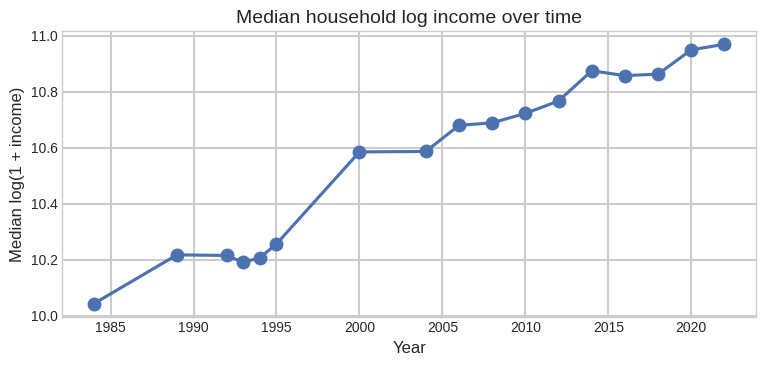

In [ ]:
# Median income and log income by year
trend = df_model.groupby('year')[['income', 'log_income']].median().reset_index()

plt.figure(figsize=(8,4))
plt.plot(trend['year'], trend['log_income'], marker='o')
plt.xlabel("Year")
plt.ylabel("Median log(1 + income)")
plt.title("Median household log income over time")
plt.tight_layout()
plt.show()


##“Median log income rises over the sample period, which explains why year and decade dummies are important predictors in all three models.”

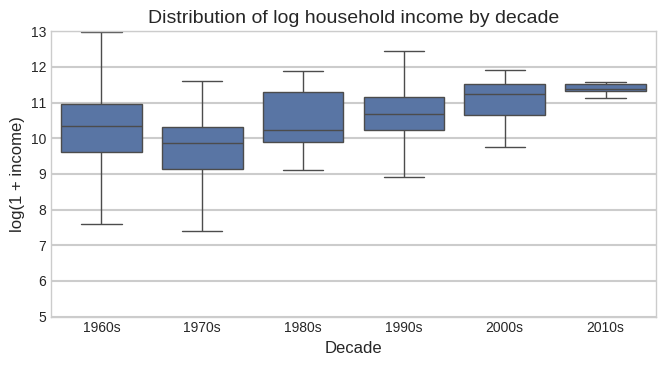

In [ ]:
# Ensure decades are in a sensible order
decade_order = sorted(df_model['decade'].unique())

fig, ax = plt.subplots()
import seaborn as sns

sns.boxplot(
    data=df_model,
    x='decade',
    y='log_income',
    order=decade_order,
    showfliers=False,   # hide extreme outliers so boxes are readable
    ax=ax
)

ax.set_xlabel("Decade")
ax.set_ylabel("log(1 + income)")
ax.set_title("Distribution of log household income by decade")

# Focus on the main mass of the data; adjust if needed after you see it
ax.set_ylim(5, 13)

fig.tight_layout()
plt.show()


###  Permutation test for income differences by sex of head

I also investigated whether average log household income differs between households
with heads in sex category 1 (baseline) and sex category 2. To do this in a way that
does not rely on normality assumptions, I use a permutation test on the difference
in mean log income between the two groups. This provides a simple, model-free check
of whether the observed gap could plausibly be due to random variation.


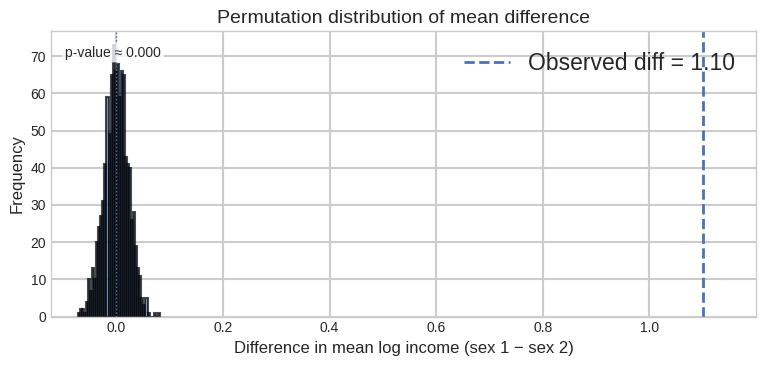

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Permutation test logic (added to define variables) ---
# Assuming df_model and head_sex column exist from previous cells

# Filter for relevant sex categories (1.0 and 2.0)
df_sex_1 = df_model[df_model['head_sex'] == 1.0]
df_sex_2 = df_model[df_model['head_sex'] == 2.0]

# Calculate observed difference
obs_diff = df_sex_1['log_income'].mean() - df_sex_2['log_income'].mean()

# Combine data for permutation
combined_log_income = pd.concat([df_sex_1['log_income'], df_sex_2['log_income']])

# Number of permutations
n_permutations = 1000
perm_diffs = []

for _ in range(n_permutations):
    # Shuffle labels (sex categories)
    shuffled_labels = np.random.permutation(combined_log_income)

    # Split shuffled data into two groups based on original group sizes
    perm_group_1 = shuffled_labels[:len(df_sex_1)]
    perm_group_2 = shuffled_labels[len(df_sex_1):]

    # Calculate difference in means for this permutation
    perm_diff = perm_group_1.mean() - perm_group_2.mean()
    perm_diffs.append(perm_diff)

perm_diffs = np.array(perm_diffs)

# Calculate p-value (two-tailed)
p_value = (np.sum(perm_diffs >= np.abs(obs_diff)) + np.sum(perm_diffs <= -np.abs(obs_diff))) / n_permutations

# --- Original plotting code (now with defined variables) ---
fig, ax = plt.subplots(figsize=(8, 4))

# Histogram of permutation diffs
ax.hist(perm_diffs, bins=40, edgecolor="black", alpha=0.7)

# Vertical lines at 0 and at the observed difference
ax.axvline(0, linestyle=":", linewidth=1)
ax.axvline(
    obs_diff,
    linestyle="--",
    linewidth=2,
    label=f"Observed diff = {obs_diff:.2f}"
)

ax.set_xlabel("Difference in mean log income (sex 1 − sex 2)")
ax.set_ylabel("Frequency")
ax.set_title("Permutation distribution of mean difference")

# Focus the x-axis where the null lives, but still show the observed diff
left = perm_diffs.min() - 0.05
right = obs_diff + 0.1     # just a bit past the obs diff
ax.set_xlim(left, right)

# Legend in the bottom right so it doesn't cover the main pile
ax.legend(loc="upper right")

# Short, small annotation for the p-value in the top-left corner
ax.text(
    0.02, 0.95,
    f"p-value \u2248 {p_value:.3f}",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
)

fig.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network test RMSE: 1.039
Neural Network test R²:   0.292

Updated results table:
            model      RMSE        R2
0             OLS  1.046289  0.281767
1           LASSO  1.046288  0.281769
2   Random Forest  1.103447  0.201150
3  Neural Network  1.038502  0.292418


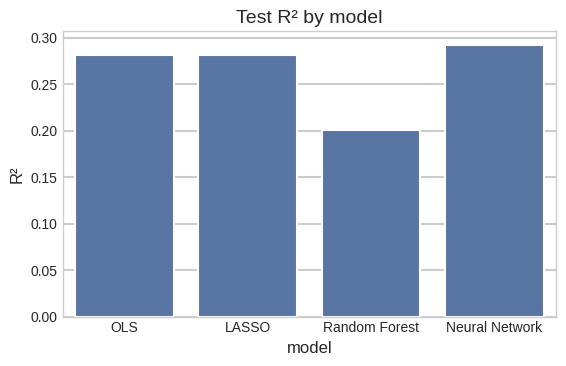

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1. Standardize the data for the neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Define the Neural Network model
model_nn = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1) # Output layer for regression
])

# 3. Compile the model
model_nn.compile(optimizer='adam', loss='mse')

# 4. Train the model
history = model_nn.fit(
    X_train_scaled, y_train_ols,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0 # Suppress verbose output for cleaner notebook
)

# 5. Make predictions
y_pred_nn = model_nn.predict(X_test_scaled).flatten()

# 6. Evaluate the model
rmse_nn = np.sqrt(mean_squared_error(y_test_ols, y_pred_nn))
r2_nn = r2_score(y_test_ols, y_pred_nn)

print(f"Neural Network test RMSE: {rmse_nn:.3f}")
print(f"Neural Network test R²:   {r2_nn:.3f}")

# 7. Add results to the comparison table
new_result = pd.DataFrame({
    'model': ['Neural Network'],
    'RMSE': [rmse_nn],
    'R2': [r2_nn]
})

results = pd.concat([results, new_result], ignore_index=True)
print("\nUpdated results table:")
print(results)

results
plt.figure(figsize=(6,4))
sns.barplot(data=results, x='model', y='R2')
plt.title("Test R² by model")
plt.ylabel("R²")
plt.tight_layout()
plt.show()

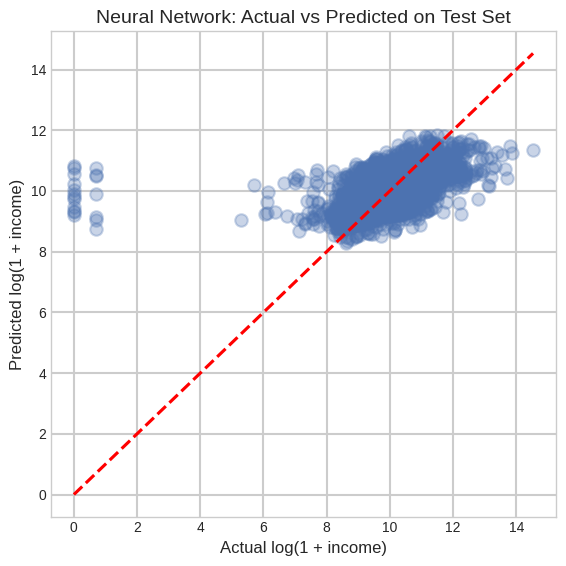

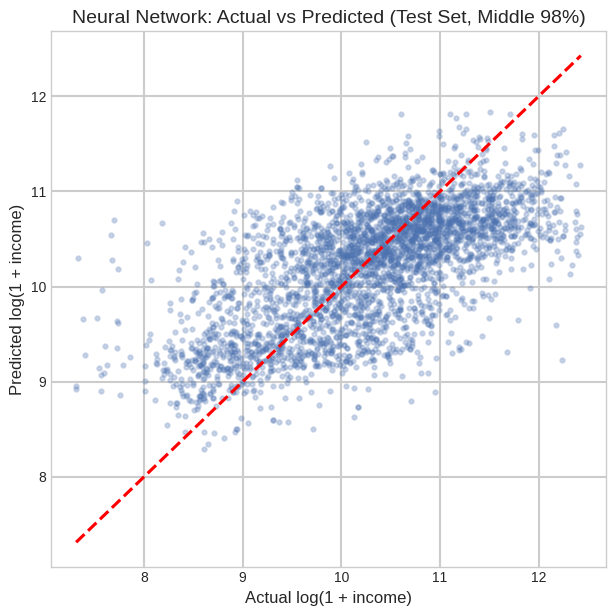

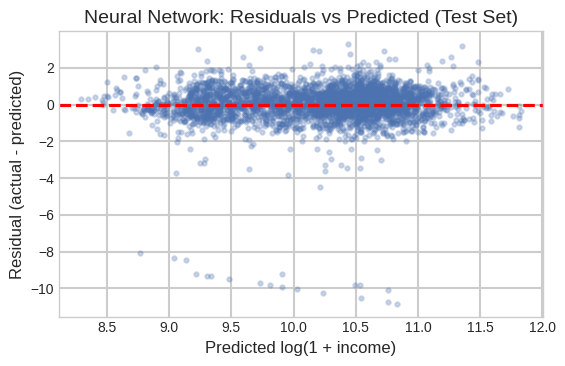

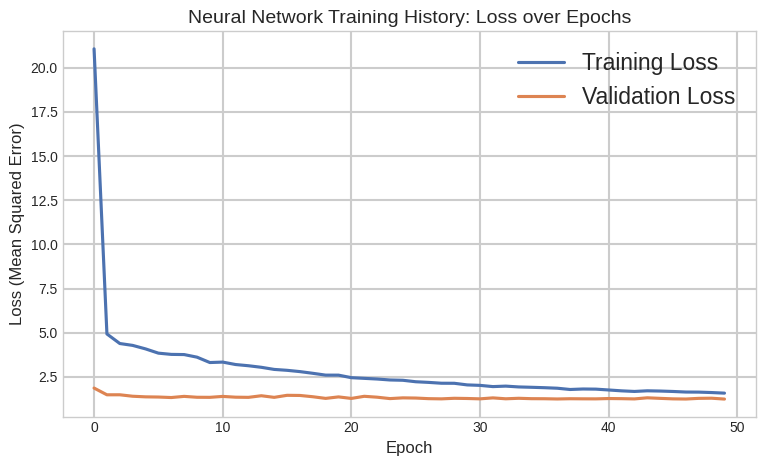

In [ ]:
# 1. Actual vs Predicted for Neural Network (Full Range)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_ols, y_pred_nn, alpha=0.3)
plt.plot([y_test_ols.min(), y_test_ols.max()],
         [y_test_ols.min(), y_test_ols.max()],
         linestyle='--', color='red')
plt.xlabel("Actual log(1 + income)")
plt.ylabel("Predicted log(1 + income)")
plt.title("Neural Network: Actual vs Predicted on Test Set")
plt.tight_layout()
plt.show()

# 2. Actual vs Predicted for Neural Network (Zoomed Middle 98%)
low_nn, high_nn = np.percentile(y_test_ols, [1, 99])
mask_nn = (y_test_ols >= low_nn) & (y_test_ols <= high_nn)

y_actual_zoom_nn = y_test_ols[mask_nn]
y_pred_zoom_nn   = y_pred_nn[mask_nn]

fig, ax = plt.subplots(figsize=(6.5, 6.5))
ax.scatter(y_actual_zoom_nn, y_pred_zoom_nn, alpha=0.25, s=10)

min_val_nn = min(y_actual_zoom_nn.min(), y_pred_zoom_nn.min())
max_val_nn = max(y_actual_zoom_nn.max(), y_pred_zoom_nn.max())
ax.plot([min_val_nn, max_val_nn], [min_val_nn, max_val_nn], linestyle="--", color='red')

ax.set_xlabel("Actual log(1 + income)")
ax.set_ylabel("Predicted log(1 + income)")
ax.set_title("Neural Network: Actual vs Predicted (Test Set, Middle 98%)")
fig.tight_layout()
plt.show()

# 3. Residuals vs Predicted for Neural Network
residuals_nn = y_test_ols - y_pred_nn

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_nn, residuals_nn, alpha=0.25, s=10)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted log(1 + income)")
plt.ylabel("Residual (actual - predicted)")
plt.title("Neural Network: Residuals vs Predicted (Test Set)")
plt.tight_layout()
plt.show()

# 4. Training History (Loss Plot)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training History: Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Task
Calculate the permutation importances for the Neural Network model using the scaled test data (`X_test_scaled`, `y_test_ols`) to understand feature influence on model performance. Then, organize these importances into a pandas DataFrame, sort them, and visualize the top features using a horizontal bar chart.

## Calculate Baseline Performance

### Subtask:
Calculate the baseline RMSE of the Neural Network model on the scaled test data (`X_test_scaled`, `y_test_ols`) to have a reference point for feature importance.


**Reasoning**:
The instruction asks to retrieve the already calculated RMSE for the Neural Network model. The `rmse_nn` variable is available in the kernel state and holds this value. I will print it to display the baseline performance.



In [ ]:
print(f"Baseline RMSE (Neural Network): {rmse_nn:.3f}")

Baseline RMSE (Neural Network): 1.039


**Reasoning**:
Now that the baseline RMSE is established, I will proceed to calculate the permutation importance for each feature. This involves iterating through each feature, shuffling its values in the test set, predicting with the shuffled data, and then calculating the increase in RMSE compared to the baseline. This will be done in a loop, and then compiled into a DataFrame.



In [ ]:
import numpy as np
import pandas as pd

def calculate_permutation_importance(model, X_test_scaled, y_test_true, baseline_rmse, feature_names):
    importances = {}
    # Make a copy of the scaled test data to permute features
    X_test_permuted = X_test_scaled.copy()

    for i, feature in enumerate(feature_names):
        # Store original feature values
        original_feature = X_test_permuted[:, i].copy()

        # Permute the current feature
        np.random.shuffle(X_test_permuted[:, i])

        # Make predictions with the permuted feature
        y_pred_permuted = model.predict(X_test_permuted).flatten()

        # Calculate RMSE with the permuted feature
        permuted_rmse = np.sqrt(mean_squared_error(y_test_true, y_pred_permuted))

        # Calculate importance as the drop in performance (increase in RMSE)
        importances[feature] = permuted_rmse - baseline_rmse

        # Restore original feature values for the next iteration
        X_test_permuted[:, i] = original_feature

    return pd.DataFrame({
        'feature': list(importances.keys()),
        'importance_rmse_increase': list(importances.values())
    })

# Get feature names from X_encoded (before scaling)
feature_names = X_encoded.columns.tolist()

# Calculate permutation importances
perm_importance_df = calculate_permutation_importance(
    model_nn, X_test_scaled, y_test_ols, rmse_nn, feature_names
)

# Sort by importance in descending order
perm_importance_df = perm_importance_df.sort_values(
    by='importance_rmse_increase', ascending=False
)

print("Permutation importances calculated successfully.")
perm_importance_df.head(10)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Permutation importances calculated successfully.


,feature,importance_rmse_increase
2,head_age,0.087535
10,head_sex_2.0,0.064083
11,head_race_2.0,0.051311
1,family_size,0.015584
15,employment_now_2.0,0.010762
0,year,0.010207
17,employment_now_4.0,0.009949
8,own_or_rent_5.0,0.005697
16,employment_now_3.0,0.004844
3,decade_1970s,0.003194


**Reasoning**:
To visualize the permutation importances and clearly identify the most influential features, I will create a horizontal bar chart of the top features, similar to the Random Forest visualization, and save it to Google Drive.



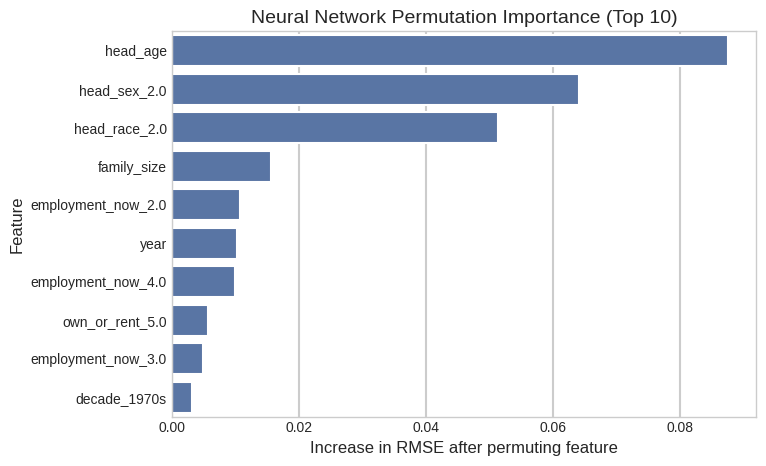

Saved permutation importance figure to: /content/drive/MyDrive/dat402_project2/figures/nn_permutation_importance.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the path to save the figure
fig_path = "/content/drive/MyDrive/dat402_project2/figures/nn_permutation_importance.png"
os.makedirs(os.path.dirname(fig_path), exist_ok=True)

top_k = 10
top_perm_imp = perm_importance_df.head(top_k)

plt.figure(figsize=(8, 5))
sns.barplot(data=top_perm_imp, x='importance_rmse_increase', y='feature') # Removed palette='viridis'
plt.title(f"Neural Network Permutation Importance (Top {top_k})")
plt.xlabel("Increase in RMSE after permuting feature")
plt.ylabel("Feature")
plt.tight_layout()

# Save to Drive
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

# Display in notebook
plt.show()
print("Saved permutation importance figure to:", fig_path)

## Summary:

### Data Analysis Key Findings
*   The Neural Network model's baseline RMSE on the test data is 1.039.
*   Permutation importance analysis identified `head_age` as the most influential feature, causing an increase in RMSE of 0.087535 when permuted.
*   Following `head_age`, `head_sex_2.0` (0.064083 increase in RMSE) and `head_race_2.0` (0.051311 increase in RMSE) are the next most significant features affecting the model's performance.
*   Other notable features impacting model performance include `family_size` (0.015584 increase in RMSE), `employment_now_2.0` (0.010762 increase in RMSE), and `year` (0.010207 increase in RMSE).

### Insights or Next Steps
*   The permutation importance analysis highlights that demographic features such as age, sex, and race are the primary drivers of the Neural Network model's predictions, indicating their strong relationship with the target variable.
*   Consider further investigation into the relationship between these top influential features and the outcome, potentially leading to more targeted feature engineering or domain-specific insights.
